In [1]:
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re

In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [3]:
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect

1)What is the % growth in the tweet as compared to last month?
2)How many % of tweets were of positive sentiments
3)Top 5 most viral tweets (based upon retweets)
4)How many influential people are talking about our product (whose followers are greater than 1000)
5)Which geographical location has the most tweets


# Web Scrapping Twitter Data

In [4]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
attributes_container = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(#t20wc2022,T20WC2022,t20WC) until:2022-11-13 since:2022-10-16').get_items()):
    if i>5000:
        break
    attributes_container.append([tweet.user.username, tweet.date,tweet.date.day,tweet.date.month, tweet.likeCount, tweet.sourceLabel, tweet.content,
                                 tweet.user.location,tweet.retweetCount,tweet.user.verified,tweet.user.followersCount])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(attributes_container, columns=["User", "Date Created","Day","Month", "Number of Likes", "Source of Tweet", "Tweet",
                                                       "Location","RetweetCount","Is Verified","Followers"])


In [5]:
tweets_df.dtypes

User                            object
Date Created       datetime64[ns, UTC]
Day                              int64
Month                            int64
Number of Likes                  int64
Source of Tweet                 object
Tweet                           object
Location                        object
RetweetCount                     int64
Is Verified                       bool
Followers                        int64
dtype: object

# Clean Tweets

In [6]:
clean_tweets = []
for tweet in tweets_df['Tweet']:
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub("#[A-Za-z0-9]+","",tweet) #Remove # sign
    tweet = re.sub(r"[^a-zA-Z0-9]+", ' ',tweet)
#     tweet = re.sub("[^0-9a-zA-Z]+","",tweet)
    ##Here's where all the cleaning takes place
    clean_tweets.append(tweet)
tweets_df['Tweet'] = clean_tweets

In [7]:
tweets_df['Tweet']

0               Best of Luck Greens https t co ppXufPYqYF
1                                                        
2       Join the contest and win prize up to 5 00 000 ...
3             https t co AdjdLFMzN2 https t co wQ7bIVnwWe
4               Stats are Beautiful https t co FXWc3qXcgE
                              ...                        
2636    Qualifying round Game 01 SL vs NAM https t co ...
2637     Sweet Reminder The first day of T20 World Cup...
2638    All the best and company Let s bring this one ...
2639    T20 World Cup 2022 Sri Lanka play Namibia Dutc...
2640    T20 World Cup 2022 Sri Lanka play Namibia Dutc...
Name: Tweet, Length: 2641, dtype: object

# Calculate Sentiment

In [8]:
# def sentiment_calc(text):
#     try:
#         analysis = TextBlob(text)
#         return analysis.sentiment.polarity
        
#     except:
#         return None

# tweets_df['sentiment'] = tweets_df['Tweet'].apply(sentiment_calc)

In [8]:
def sentiment_calc(text):
    try:
        analysis = TextBlob(text)
        if analysis.sentiment.polarity > 0:
            return 'Positive'
        elif analysis.sentiment.polarity == 0:
            return 'Neutral'
        else:
            return 'Negative'
        
    except:
        return None

tweets_df['sentiment_analysis'] = tweets_df['Tweet'].apply(sentiment_calc)

In [9]:
tweets_df['sentiment_analysis'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

## Total Sentimental value count

In [10]:
print("Total Positive Value:",tweets_df['sentiment_analysis'].value_counts()['Positive'])
print("Total Neutral Value:",tweets_df['sentiment_analysis'].value_counts()['Neutral'])
print("Total Negative Value:",tweets_df['sentiment_analysis'].value_counts()['Negative'])

Total Positive Value: 1070
Total Neutral Value: 1390
Total Negative Value: 181


# Total Percentage of Sentimental

In [11]:
print("Total Positive Value percentage:",tweets_df['sentiment_analysis'].value_counts(normalize=True)['Positive']*100,2)
print("Total Neutral Value percentage:",tweets_df['sentiment_analysis'].value_counts(normalize=True)['Neutral']*100,2)
print("Total Negative Value percentage:",tweets_df['sentiment_analysis'].value_counts(normalize=True)['Negative']*100,2)

Total Positive Value percentage: 40.514956455887926 2
Total Neutral Value percentage: 52.63157894736842 2
Total Negative Value percentage: 6.853464596743658 2


# Popular Tweet Based On Retweet Count

In [12]:
top_viral_tweet_df=tweets_df.sort_values('RetweetCount', ascending=False)

In [13]:
top_viral_tweet_df.head(5)

,User,Date Created,Day,Month,Number of Likes,Source of Tweet,Tweet,Location,RetweetCount,Is Verified,Followers,sentiment_analysis
1568,MPRakeshSingh,2022-10-27 12:39:59+00:00,27,10,185,Twitter for Android,56 https t co VBimuDtLaq,"Jabalpur, India",161,True,242403,Neutral
1043,Cric_beat,2022-11-01 16:04:28+00:00,1,11,947,Twitter for Android,Most 50 Scores in T20WC by Indian Middle Order...,fambeatsports@gmail.com,90,False,40954,Positive
1262,Thyview,2022-10-30 12:13:42+00:00,30,10,995,Twitter for Android,50 for An important knock in a very crucial ti...,,88,True,181719,Positive
1977,awardslivenow,2022-10-23 07:16:45+00:00,23,10,79,Twitter Web App,Watch 2022 ICC Men s Cricket T20 World Cup Liv...,Click Here,78,False,508,Positive
1321,Thyview,2022-10-30 10:34:50+00:00,30,10,479,Twitter for Android,won the toss and decided to bat first against,,32,True,181719,Positive


# Calculate Growth Difference Between Two Months

In [14]:
tweets_df['Month'].unique()

array([11, 10], dtype=int64)

In [15]:
November_df=tweets_df.loc[tweets_df['Month']==11] 

In [16]:
November_df['Tweet'].count()

1116

In [17]:
Octomber_df=tweets_df.loc[tweets_df['Month']==10] 

In [18]:
Octomber_df['Tweet'].count()

1525

In [19]:
print("Growth compare to two months:",(November_df['Tweet'].count()-Octomber_df['Tweet'].count())/Octomber_df['Tweet'].count()*100)

Growth compare to two months: -26.81967213114754


# Which geographical location has the most tweets

In [20]:
tweets_df['Location'].unique()

array(['', 'Uttar Pradesh, India', 'New Delhi, India',
       'New Delhi - Sagar (M.P)', 'Mumbai, India', '#Dubai #News',
       'Pakistan', 'Mumbai', 'Indore, India', 'Hindusthan', 'Texas, USA',
       'India', 'Karachi, Pakistan', 'New Delhi', 'chennai',
       'INDIA DEHRADUN', 'Bengaluru', 'Raipur, India',
       'Jaipur, Rajasthan', 'Jamshedpur, India', 'Ambala',
       'Lahore, Pakistan', 'Singapore', 'Orlando, Florida, USA',
       'Bangladesh', 'Maharashtra', 'Dubai, United Arab Emirates',
       'Dev Bhoomi ', 'Bhopal, India', 'Chennai', 'mai nhi bataunga',
       'Global', 'Dhaka, Bangladesh', 'Kerala, India', '𝒫𝒶𝓉𝓃𝒶 𝒷𝒾𝒽𝒶𝓇',
       'London', 'Nottingham, England', 'Ghaziabad, India',
       'smart citizen  kota rajasthan', 'Chitamba karera Rajasthan',
       'Pune, India', 'Pune', 'Belapur, Navi Mumbai',
       '595, Budhwar Peth, Pune', 'World', 'Indore',
       'Islamabad, Pakistan', 'lucknow', 'Lahore, پنجاب, پاکستان',
       'United Arab Emirates', 'At Cricket', 'Kolkata,

In [21]:
df=tweets_df.copy()

In [22]:
df.shape

(2641, 12)

In [23]:
# Replace multiple values with a new value for an individual DataFrame column.
df['Location'] = df['Location'].replace([''],'Not mentioned')

In [24]:
location_stats = df['Location'].value_counts(ascending=False)
location_stats

Not mentioned                     1305
Jaipur, Rajasthan                  151
Raipur, India                      146
India                              111
Mumbai                              81
                                  ... 
Nellore, Andhra Pradesh, India       1
Truckers Rally Ukraine Russia        1
Ranchi, India                        1
Delhi, India                         1
Non-Striker's End                    1
Name: Location, Length: 271, dtype: int64

In [25]:
location_less_than_10=location_stats[location_stats<=10]
location_less_than_10

Islamabad, Pakistan               9
New Delhi                         9
Kolkata                           8
Texas, USA                        8
Somewhere in 🌐                    8
                                 ..
Nellore, Andhra Pradesh, India    1
Truckers Rally Ukraine Russia     1
Ranchi, India                     1
Delhi, India                      1
Non-Striker's End                 1
Name: Location, Length: 248, dtype: int64

In [26]:
df['Location'] = df.Location.apply(lambda x: 'other' if x in location_less_than_10 else x)


In [27]:
df['Location'].value_counts()

Not mentioned         1305
other                  422
Jaipur, Rajasthan      151
Raipur, India          146
India                  111
Mumbai                  81
Sri Lanka               61
Bhopal                  48
Bhopal, India           48
New Delhi, India        29
Hyderabad, India        29
Jamshedpur, India       28
Karachi, Pakistan       27
india                   25
Mumbai, India           16
Global                  15
World                   15
Bengaluru, India        13
Mainly at Stadium       13
Agartala, India         13
Hyderabad               12
Kerala, India           11
Pakistan                11
Gampaha, Sri Lanka      11
Name: Location, dtype: int64

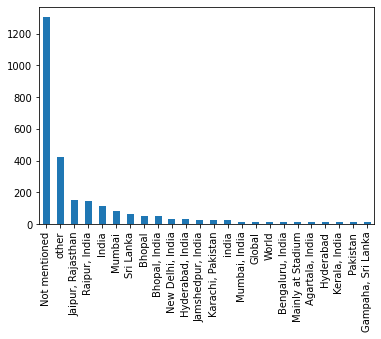

In [28]:
df['Location'].value_counts().plot(kind='bar');

# How many influential people are talking about T20Wc

In [29]:
df.columns

Index(['User', 'Date Created', 'Day', 'Month', 'Number of Likes',
       'Source of Tweet', 'Tweet', 'Location', 'RetweetCount', 'Is Verified',
       'Followers', 'sentiment_analysis'],
      dtype='object')

In [30]:
df['Is Verified'].sum()

318

people are influential or we can say which are celebrities

In [32]:
verified_user_df=df[df['Is Verified']==True].groupby(['User', 'Date Created', 'Day', 'Month', 'Number of Likes',
       'Source of Tweet', 'Tweet', 'Location', 'RetweetCount', 'Is Verified',
       'Followers', 'sentiment_analysis']).size().reset_index(name='count')

In [33]:
verified_user_df.head()

,User,Date Created,Day,Month,Number of Likes,Source of Tweet,Tweet,Location,RetweetCount,Is Verified,Followers,sentiment_analysis,count
0,ABPDesam,2022-10-18 14:01:00+00:00,18,10,1,Twitter Web App,20 https t co Mo5ANDEzmA,Hyderabad,0,True,2242,Neutral,1
1,ABPDesam,2022-10-21 12:45:00+00:00,21,10,0,Twitter Web App,https t co 40kpyaVwD9,Hyderabad,0,True,2242,Neutral,1
2,ABPDesam,2022-10-26 14:15:00+00:00,26,10,0,Twitter Web App,https t co L1dn3dpcMG,Hyderabad,0,True,2242,Neutral,1
3,ABPDesam,2022-11-02 16:40:00+00:00,2,11,1,Twitter Web App,https t co 46wyzTNoH6,Hyderabad,0,True,2242,Neutral,1
4,ABPDesam,2022-11-03 08:00:00+00:00,3,11,0,Twitter Web App,https t co HKGtbs4d1O,Hyderabad,0,True,2242,Neutral,1


In [34]:
verified_user_df['User'].unique()

array(['ABPDesam', 'AdityaPimpale6', 'AmarUjalaNews', 'AsianetNewsBN',
       'AsianetNewsHN', 'BOLNETWORK', 'DH_Tamil', 'DailyUrduPoint',
       'ETimesLifestyle', 'JagranNews', 'LoksattaLive', 'MPRakeshSingh',
       'ManaTelanganaIN', 'News18CG', 'News18India', 'News18Kannada',
       'News18MP', 'News18TamilNadu', 'News18_Sports', 'Onmanorama',
       'PlayerzPot', 'SakalMediaNews', 'TNNavbharat', 'TV9Marathi',
       'Tamilmirror', 'ThanthiTV', 'Thyview', 'abhisheksdixit',
       'apnlivehindi', 'betcoza', 'cricket_country', 'hardevrr',
       'indiacom', 'indiatvnews', 'latestly', 'lokmat', 'mataonline',
       'mid_day', 'mohanstatsman', 'nitinagarwal_n', 'oneindiagujarat',
       'supergillies', 'theagesport', 'toisports', 'vivekrajpoot47',
       'zee24taasnews'], dtype=object)

# 10000 atleast followers as influential people

In [35]:
influential_people=verified_user_df.loc[verified_user_df['Followers']>10000] 

In [36]:
influential_people['User'].unique()

array(['AmarUjalaNews', 'BOLNETWORK', 'DH_Tamil', 'DailyUrduPoint',
       'ETimesLifestyle', 'JagranNews', 'LoksattaLive', 'MPRakeshSingh',
       'News18CG', 'News18India', 'News18Kannada', 'News18MP',
       'News18TamilNadu', 'Onmanorama', 'PlayerzPot', 'SakalMediaNews',
       'TNNavbharat', 'TV9Marathi', 'Tamilmirror', 'ThanthiTV', 'Thyview',
       'apnlivehindi', 'betcoza', 'cricket_country', 'indiacom',
       'indiatvnews', 'latestly', 'lokmat', 'mataonline', 'mid_day',
       'mohanstatsman', 'nitinagarwal_n', 'oneindiagujarat',
       'supergillies', 'theagesport', 'toisports', 'zee24taasnews'],
      dtype=object)

In [37]:
# tweets_df.to_csv('WEB SCRAPPING T20WC TWEETS.csv')

<h3> QNS>1)What is the % growth in the tweet as compared to last month? 


In [38]:
print("Growth compare to two months:",(November_df['Tweet'].count()-Octomber_df['Tweet'].count())/Octomber_df['Tweet'].count()*100)

Growth compare to two months: -26.81967213114754


<h3>Qns>2)How many % of tweets were of positive sentiments

In [39]:
print("Total Positive Value:",tweets_df['sentiment_analysis'].value_counts()['Positive'])

Total Positive Value: 1070


<h3>Qns>3)Top 5 most viral tweets (based upon retweets)

In [41]:
top_viral_tweet_df.head(5)

,User,Date Created,Day,Month,Number of Likes,Source of Tweet,Tweet,Location,RetweetCount,Is Verified,Followers,sentiment_analysis
1568,MPRakeshSingh,2022-10-27 12:39:59+00:00,27,10,185,Twitter for Android,56 https t co VBimuDtLaq,"Jabalpur, India",161,True,242403,Neutral
1043,Cric_beat,2022-11-01 16:04:28+00:00,1,11,947,Twitter for Android,Most 50 Scores in T20WC by Indian Middle Order...,fambeatsports@gmail.com,90,False,40954,Positive
1262,Thyview,2022-10-30 12:13:42+00:00,30,10,995,Twitter for Android,50 for An important knock in a very crucial ti...,,88,True,181719,Positive
1977,awardslivenow,2022-10-23 07:16:45+00:00,23,10,79,Twitter Web App,Watch 2022 ICC Men s Cricket T20 World Cup Liv...,Click Here,78,False,508,Positive
1321,Thyview,2022-10-30 10:34:50+00:00,30,10,479,Twitter for Android,won the toss and decided to bat first against,,32,True,181719,Positive


<h3>Qns>4)How many influential people are talking about our product (whose followers are greater than 1000)

In [42]:
influential_people['User'].unique()

array(['AmarUjalaNews', 'BOLNETWORK', 'DH_Tamil', 'DailyUrduPoint',
       'ETimesLifestyle', 'JagranNews', 'LoksattaLive', 'MPRakeshSingh',
       'News18CG', 'News18India', 'News18Kannada', 'News18MP',
       'News18TamilNadu', 'Onmanorama', 'PlayerzPot', 'SakalMediaNews',
       'TNNavbharat', 'TV9Marathi', 'Tamilmirror', 'ThanthiTV', 'Thyview',
       'apnlivehindi', 'betcoza', 'cricket_country', 'indiacom',
       'indiatvnews', 'latestly', 'lokmat', 'mataonline', 'mid_day',
       'mohanstatsman', 'nitinagarwal_n', 'oneindiagujarat',
       'supergillies', 'theagesport', 'toisports', 'zee24taasnews'],
      dtype=object)

<h3>Qns>5)Which geographical location has the most tweets

In [43]:
df['Location'].value_counts()

Not mentioned         1305
other                  422
Jaipur, Rajasthan      151
Raipur, India          146
India                  111
Mumbai                  81
Sri Lanka               61
Bhopal                  48
Bhopal, India           48
New Delhi, India        29
Hyderabad, India        29
Jamshedpur, India       28
Karachi, Pakistan       27
india                   25
Mumbai, India           16
Global                  15
World                   15
Bengaluru, India        13
Mainly at Stadium       13
Agartala, India         13
Hyderabad               12
Kerala, India           11
Pakistan                11
Gampaha, Sri Lanka      11
Name: Location, dtype: int64

# EDA

Most of the data are not mentioned.So,Except them Jaipur has the most tweets geographical wise.

In [44]:
tweets_df.columns

Index(['User', 'Date Created', 'Day', 'Month', 'Number of Likes',
       'Source of Tweet', 'Tweet', 'Location', 'RetweetCount', 'Is Verified',
       'Followers', 'sentiment_analysis'],
      dtype='object')

[Text(0.5, 1.0, 'Tweet Distribute by Month')]

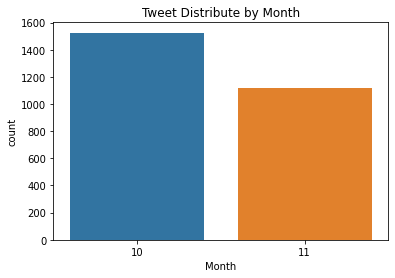

In [45]:
import seaborn as sns
sns.countplot(x="Month", data=tweets_df).set(title='Tweet Distribute by Month')

In [46]:
tweets_df['sentiment_analysis'].value_counts()

Neutral     1390
Positive    1070
Negative     181
Name: sentiment_analysis, dtype: int64

[Text(0.5, 1.0, 'Tweet Distribute by Month')]

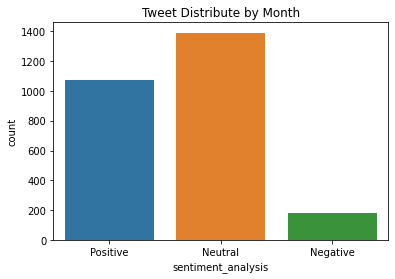

In [47]:
import seaborn as sns
sns.countplot(x="sentiment_analysis", data=tweets_df).set(title='Tweet Distribute by Month')

# Influential People

In [49]:
from PIL import Image

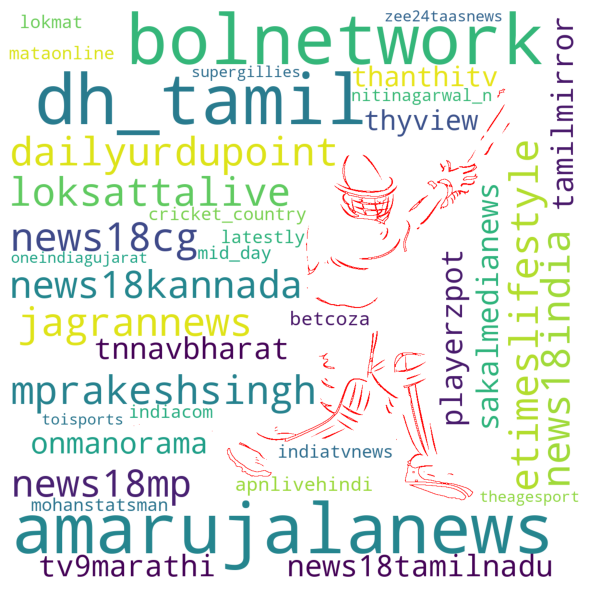

In [50]:
img_url="C:/Users/Henil/Downloads/—Pngtree—icc cricket world cup motion_6544120.png"
img_mask = np.array(Image.open(img_url))
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in influential_people['User'].unique():
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width=600, height=600, mask= img_mask, background_color = 'white',
               contour_width=1,
               contour_color='red'
              ).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Top Viral Tweets

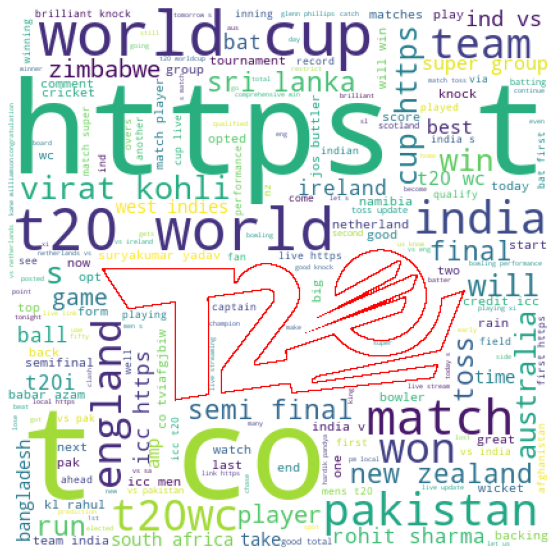

In [51]:
img_url="C:/Users/Henil/Downloads/t20wc.png"
img_mask = np.array(Image.open(img_url))
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in top_viral_tweet_df.Tweet:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "


wc = WordCloud(width=600, height=600, mask= img_mask, background_color = 'white',
               contour_width=1,
               contour_color='red'
              ).generate(comment_words)

plt.figure(figsize=[10,10])
plt.axis("off")
plt.imshow(wc)

# Location

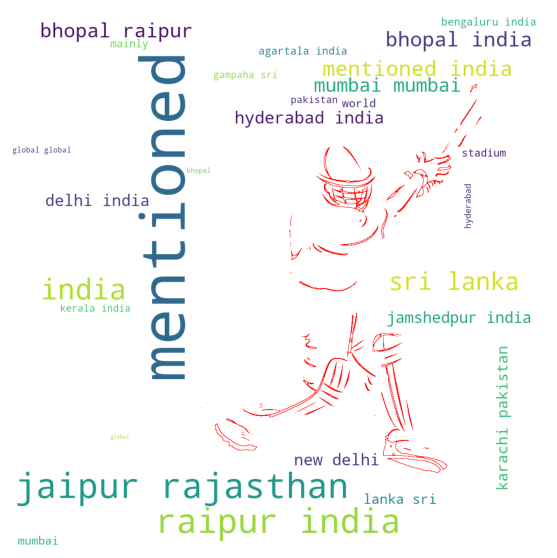

In [52]:
img_url="C:/Users/Henil/Downloads/—Pngtree—icc cricket world cup motion_6544120.png"
img_mask = np.array(Image.open(img_url))
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df['Location']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "


wc = WordCloud(width=600, height=600, mask= img_mask, background_color = 'white',
               contour_width=1,
               contour_color='red'
              ).generate(comment_words)

plt.figure(figsize=[10,10])
plt.axis("off")
plt.imshow(wc)